While the package seems to handle the synthetic data fairly well right now - I'm beginning to realise that the real data is of course likely to be much more noisy and messy -- and I need to start considering it as soon as possible. 

This notebook is basically me checking out how well real data can be handled in the current package, and what can be done to improve the CF-FM segmentation performance.

While exploring how well real-data is CF-FM segmented, I also ended up figuring out how to segment the call from the background - and this too is now part of the package. 

2020-03-10
-- Thejasvi Beleyur

In [1]:
%matplotlib notebook

In [2]:
import glob
import os
import sys 
sys.path.append('..\\measure_horseshoe_bat_calls\\')

In [3]:
import pywt
from segment_horseshoebat_call import *
from measure_a_horseshoe_bat_call import *


In [4]:
real_data = glob.glob('real_data\\'+'*.WAV')


### Loading, upsampling and storing the audio clips into a dictionary
My previous notebooks have shown that upsampling has the effect of improving FM and CF segmentation - especially for call with short FM durations. 

In [5]:
all_calls = {}
for each in real_data:
    call, fs = sf.read(each)
    call_ups = signal.resample(call, call.size*2)
    file_name = os.path.split(each)[-1]
    all_calls[file_name] = call_ups
    
    

In [6]:
all_file_names = list(all_calls.keys())

In [7]:
make_x_time = lambda X, fs: np.linspace(0, X.size/float(fs), X.size)

def visualise_call(audio, fs):
    plt.figure()
    a0 = plt.subplot(211)
    plt.plot(make_x_time(audio,fs), audio)
    a1 = plt.subplot(212, sharex=a0)
    plt.specgram(audio, Fs=fs, NFFT=128,noverlap=127, vmin=-100)
    return a0, a1

<IPython.core.display.Javascript object>


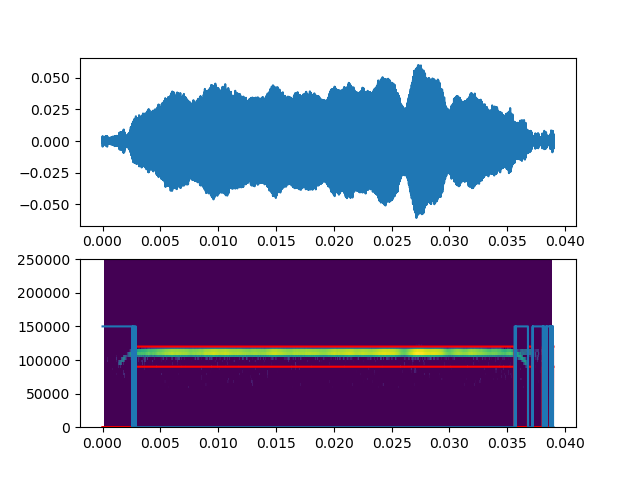

<IPython.core.display.Javascript object>


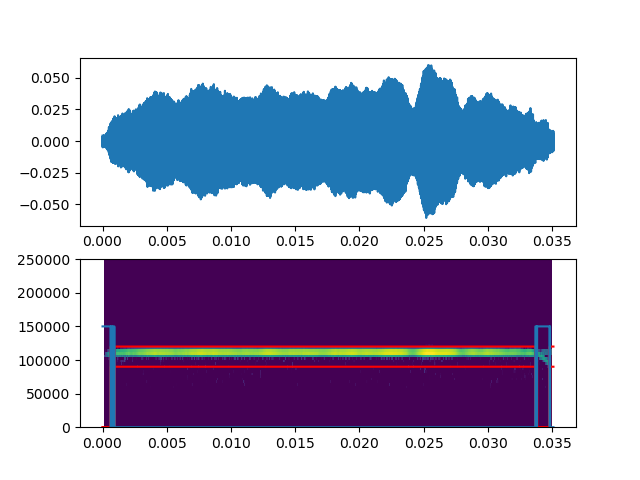

In [8]:
example_call = all_calls[all_file_names[57]]
pk_pctage = 0.985
win_size = 25

a,b = visualise_call(example_call, fs*2)
cf, fm, info = segment_call_into_cf_fm(example_call, fs*2, 
                                       peak_percentage=pk_pctage,
                                       window_size=win_size)
b.plot(make_x_time(cf,fs*2), cf*90000,'r')
b.plot(make_x_time(cf,fs*2), cf*120000,'r')
b.plot(make_x_time(fm,fs*2), fm*150000)

# get rid of the silence before and after the call
start, stop = calc_sound_borders(example_call, 90)

main_call = example_call[start:stop]
a1,b1 = visualise_call(main_call, fs*2)
cf, fm, info = segment_call_into_cf_fm(main_call, fs*2,
                                       peak_percentage=pk_pctage,
                                       window_size=win_size)
b1.plot(make_x_time(cf,fs*2), cf*90000,'r')
b1.plot(make_x_time(cf,fs*2), cf*120000,'r')
b1.plot(make_x_time(fm,fs*2), fm*150000)

### The real data have a few milliseconds of silence on the left and right of the main call - and this might also affect how the segmentation happens. Does the situation improve if we pre-select the main energy window?

### Things which make proper call-background + CF-FM segmentation tricky:
* Non-uniform received levels across the call duration (start of call is faint, but end of call is intense)
* Banding/interference in the CF and FM. The interference creates weird false CF/FM bands. This is typically a sign of a signal with some reflections in it -- though, if necessary, signals could still be recovered from it by some kind of interpolation. 

In [9]:
def segment_call_from_background(audio, fs,**kwargs):
    '''Performs a wavelet transform to track the signal within the relevant portion of the bandwidth. 
    
    Parameters
    ----------
    audio : np.array
    fs : float>0
        Frequency of sampling in Hertz. 
    lowest_relevant_freq : float>0, optional
        The lowest frequency band in Hz whose coefficients will be tracked.
        The coefficients of all frequencies in the signal >= the lowest relevant
        frequency are tracked. This is the lowest possible frequency the signal can take.
        It is best to give ~10-20 kHz of berth.
        Defaults to 35kHz.
    wavelet_type : str, optional
        The type of wavelet which will be used for the continuous wavelet transform. 
        See  pywt.wavelist(kind='continuous') for all possible types in case the default
        doesn't seem to work. 
        Defaults to mexican hat, 'mexh'
    scales : array-like, optional
    
    
    '''
    lowest_relevant_freq = kwargs.get('lowest_relevant_freq', 35000.0)
    wavelet_type = kwargs.get('wavelet_type', 'mexh')
    background_threshold = kwargs.get('background_threshold', -20)
    scales = kwargs.get('scales',np.arange(1,10))

    coefs, freqs = pywt.cwt(audio,
                            scales,
                            wavelet_type,
                            sampling_period=1.0/(fs))
    relevant_freqs = freqs[freqs>=lowest_relevant_freq]
    if np.sum(relevant_freqs) == 0:
        raise ValueError('The lowest relevant frequency is too high. Please re-check the value')
    
    within_centre_freqs = np.logical_and(np.min(freqs)<=lowest_relevant_freq,
                                         np.max(freqs)>=lowest_relevant_freq)
    if not within_centre_freqs:
        raise ValueError('The lowest relevant frequency %.2f is not included in the centre frequencies of the wavelet scales.\
                          Increase the scale range.'%np.round(lowest_relevant_freq,2))

    relevant_rows  =  int(np.argwhere(np.min(relevant_freqs)==freqs))
    summed_profile = np.sum(abs(coefs[:relevant_rows]), 0)
    
    dbrms_profile = dB(moving_rms_edge_robust(summed_profile, **kwargs))
    dbrms_profile -= np.max(dbrms_profile)

    if np.min(dbrms_profile) >= background_threshold:
        raise IncorrectThreshold('The dynamic range of the signal is lower than the background threshold.\
        Please decrease the background threshold')
    
    potential_region = identify_valid_regions(dbrms_profile>=background_threshold, 1)
    
    return potential_region

class IncorrectThreshold(ValueError):
    pass

<IPython.core.display.Javascript object>


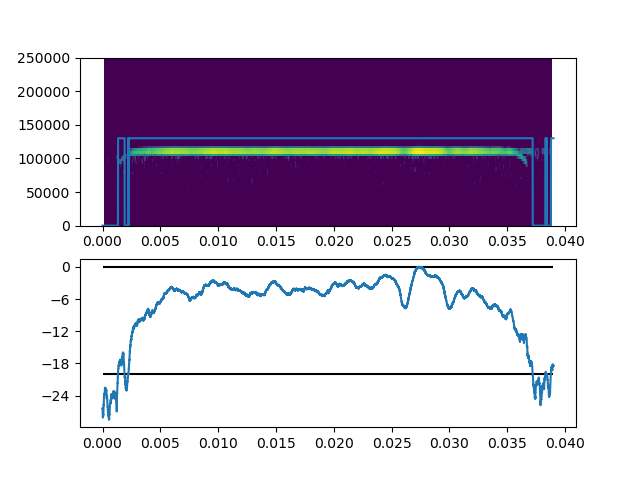

In [10]:
coefs, freqs = pywt.cwt(example_call,
                                      np.arange(1,100),
                                      'mexh',sampling_period=1/(fs*2))
#print(freqs, np.argmax(np.sum(coefs,1)))
#plt.figure()
#plt.imshow(dB(abs(coefs)), aspect='auto', origin='upper')
profile_highf = np.sum(abs(coefs[:4,:]),0)
profile_lowf = np.sum(abs(coefs[-4:,:]),0)

dbrms_highf = dB(moving_rms_edge_robust(profile_highf, window_size=75))
dbrms_highf -= np.max(dbrms_highf)

thres = -20

plt.figure()
w0 = plt.subplot(212)
plt.plot(make_x_time(dbrms_highf,fs*2), dbrms_highf)
plt.hlines(0,0,dbrms_highf.size/(fs*2))
plt.hlines(thres,0,dbrms_highf.size/(fs*2))
plt.yticks(np.arange(0,thres-6,-6),)

plt.subplot(211,sharex=w0)
plt.specgram(example_call, Fs=fs*2, NFFT=128,noverlap=127, vmin=-100);
batcall = dbrms_highf.flatten()>=thres
plt.plot(make_x_time(example_call, fs*2), batcall*130000)


<IPython.core.display.Javascript object>


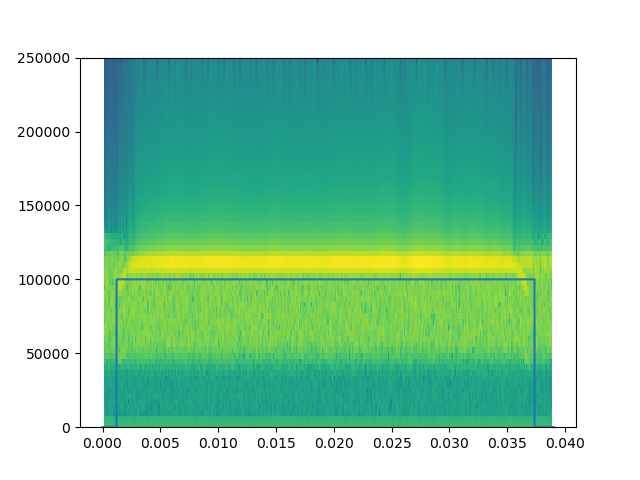

In [11]:
plt.figure()
plt.specgram(example_call, Fs=fs*2, NFFT=128,noverlap=127)
call_region = segment_call_from_background(example_call, fs*2, scales=np.arange(1,5),
                                           background_threshold=-24)
plt.plot(make_x_time(call_region, fs*2), call_region*100000)

Notes for the wavelet based call-background segmentation:

> if dynamic range of whole wavelet dbrms >= threshold dB --> throw error.

> output largest continuous chunk above threshold. 

In [12]:
import datetime as dt
print('Notebook run to the end last on:', dt.datetime.now())

Notebook run to the end last on: 2020-03-10 18:45:26.443627
